In [142]:
import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple

def generate_bounded_random_paths(
    mu: NDArray,
    cov: NDArray,
    poisson_mean: float,
    num_paths: int,
    xlim: Tuple[float, float],
    ylim: Tuple[float, float],
    zlim: Tuple[float, float]
) -> List[NDArray]:
    """Generates multiple 3D random walk paths with boundary clipping."""
    # Generate initial positions for each path (z is implicitly 0)
    init_pos = np.zeros((num_paths, 3))
    init_pos[:, 0] = np.random.uniform(*xlim, size=num_paths)
    init_pos[:, 1] = np.random.uniform(*ylim, size=num_paths)

    # Determine the number of steps for each path from a Poisson distribution
    steps_per_path = np.random.poisson(poisson_mean, size=num_paths)

    # Generate the random walk steps for all paths
    walk_steps = [np.random.multivariate_normal(mu, cov, size=s) for s in steps_per_path]

    final_paths: List[NDArray[np.float_]] = []
    for i, steps_array in enumerate(walk_steps):
        # Create a path array including the start point (t=0)
        path = np.zeros((len(steps_array) + 1, 3))
        
        # Calculate the cumulative sum of steps and add the initial position
        path[1:] = np.cumsum(steps_array, axis=0)
        path += init_pos[i]
        
        # Clip the coordinates of the entire path to the specified bounds
        np.clip(path[:, 0], *xlim, out=path[:, 0])
        np.clip(path[:, 1], *ylim, out=path[:, 1])
        np.clip(path[:, 2], *zlim, out=path[:, 2])
        
        final_paths.append(path)

    return final_paths


mu = [0,0,1]
cov = np.array([0.1,0.1,0.25]).reshape(-1,1)*np.eye(3)
poisson_mean = 50
num_paths = 50
xlim = (-20,20)
ylim = (-20,20)
zlim = (0,75)

paths = generate_bounded_random_paths(mu,cov,poisson_mean,num_paths,xlim, ylim, zlim)


In [143]:
import numpy as np
from numpy.typing import NDArray
from typing import List

def generate_intensities_for_paths(
    paths: List[NDArray],
    intensity_decay_rate: float,
    intensity_noise_std: float
) -> List[NDArray]:
    """Generates intensity values for a list of 3D paths based on depth."""
    all_intensities: List[NDArray] = []
    
    for path in paths:
        if path.shape[0] == 0:
            # Handle the case of an empty path
            all_intensities.append(np.array([]))
            continue
            
        # Extract the z-coordinates (depth) from the third column of the path
        z_coords = path[:, 2]
        z_coords[z_coords < 20] = 20
        
        # Calculate the base intensity using a vectorized exponential decay model
        base_intensities = np.random.exponential((z_coords)*intensity_decay_rate)
        
        # Generate random noise with the same shape as the number of points
        noise = np.random.normal(
            loc=0.0, 
            scale=intensity_noise_std, 
            size=path.shape[0]
        )
        
        # Combine base intensity with noise and clip at 0 to prevent negative values
        stochastic_intensities = np.maximum(0.0, base_intensities + noise)
        
        all_intensities.append(stochastic_intensities)
        
    return all_intensities

intensities = generate_intensities_for_paths(paths, 1, 10)

In [144]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from typing import List

def create_path_dataframe(
    paths: List[NDArray[np.floating]],
    intensities: List[NDArray[np.floating]]
) -> pd.DataFrame:
    """Combines lists of paths and intensities into a single Pandas DataFrame."""
    if len(paths) != len(intensities):
        raise ValueError("The number of paths must match the number of intensity arrays.")

    processed_data_list: List[NDArray[np.floating]] = []

    for path_id, (path, w_values) in enumerate(zip(paths, intensities)):
        num_points = path.shape[0]
        if num_points != w_values.shape[0]:
            raise ValueError(f"Path {path_id} and its intensity array have mismatched lengths.")
        if num_points == 0:
            continue

        # Create an ID column with the same number of rows as the path
        id_col = np.full((num_points, 1), path_id, dtype=np.int32)
        
        # Reshape the 1D intensity array into a 2D column vector
        w_col = w_values.reshape(-1, 1)
        
        # Horizontally stack the columns: [id, x, y, z, w]
        combined_array = np.hstack([id_col, path, w_col])
        processed_data_list.append(combined_array)

    if not processed_data_list:
        return pd.DataFrame(columns=['id', 'x', 'y', 'z', 'w'])

    # Vertically stack all arrays into one large array
    final_array = np.vstack(processed_data_list)
    
    # Create the DataFrame from the final array with specified column names
    df = pd.DataFrame(final_array, columns=['id', 'x', 'y', 'z', 'w'])
    
    # Ensure correct data types for columns
    df = df.astype({'id': int, 'x': float, 'y': float, 'z': float, 'w': float})
    
    return df

data = create_path_dataframe(paths, intensities)

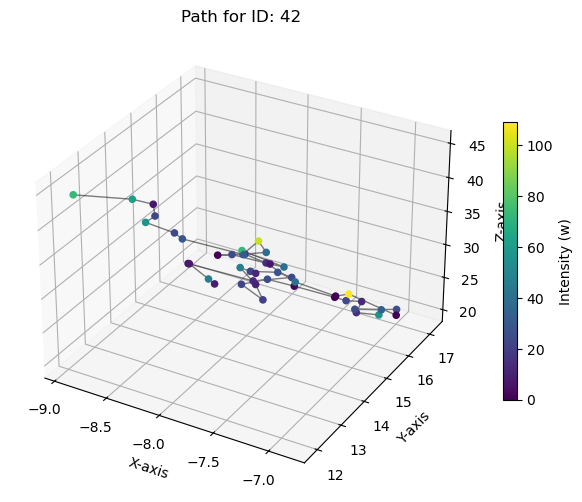

In [145]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from typing import Optional, Tuple, Dict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_path_with_intensity_gradient(
    df: pd.DataFrame,
    path_id: int,
    ax: Optional[Axes3D] = None,
    bounds: Optional[Tuple[Tuple[float, float], ...]] = None
) -> None:
    """Plots a 3D path with a connecting line and intensity-colored markers."""
    # 1. Filter the DataFrame for the specified path ID
    path_data = df[df['id'] == path_id]
    if path_data.empty:
        raise ValueError(f"Path with id {path_id} not found in the DataFrame.")

    # 2. Set up the figure and axes if not provided
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    else:
        fig = ax.get_figure()

    # 3. Extract data for plotting
    x = path_data['x'].values
    y = path_data['y'].values
    z = path_data['z'].values
    w = path_data['w'].values

    # 4. Create the plot
    # First, draw the connecting line for the trajectory
    ax.plot(x, y, z, color='black', alpha=0.5, linewidth=1)
    
    # Then, draw the scatter points with colors mapped to intensity
    scatter = ax.scatter(x, y, z, c=w, cmap='viridis', s=20, depthshade=False)

    # 5. Add a colorbar to serve as a legend for the intensity
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=20)
    cbar.set_label('Intensity (w)')

    # 6. Set axis limits and labels for context
    if bounds:
        xlim, ylim, zlim = bounds
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title(f"Path for ID: {path_id}")


plot_path_with_intensity_gradient(data, 42)

In [146]:
def create_event_images(data: pd.DataFrame, image_size: Tuple[int, int] = (256, 256)) -> Dict[int, np.ndarray]:
    """Converts event data into 2D images."""
    images: Dict[int, np.ndarray] = {}
    x_min, x_max = data['x'].min(), data['x'].max()
    y_min, y_max = data['y'].min(), data['y'].max()
    x_range = x_max - x_min if x_max > x_min else 1
    y_range = y_max - y_min if y_max > y_min else 1
    for event_id, event_df in data.groupby('id'):
        x_coords, y_coords, w_values = event_df['x'].values, event_df['y'].values, event_df['w'].values
        col_indices = np.clip(((x_coords - x_min) / x_range * (image_size[1] - 1)).astype(np.int32), 0, image_size[1] - 1)
        row_indices = np.clip(((y_coords - y_min) / y_range * (image_size[0] - 1)).astype(np.int32), 0, image_size[0] - 1)
        image_canvas = np.zeros(image_size, dtype=np.float32)
        np.add.at(image_canvas, (row_indices, col_indices), w_values)
        images[event_id] = image_canvas
    return images

images = create_event_images(data)

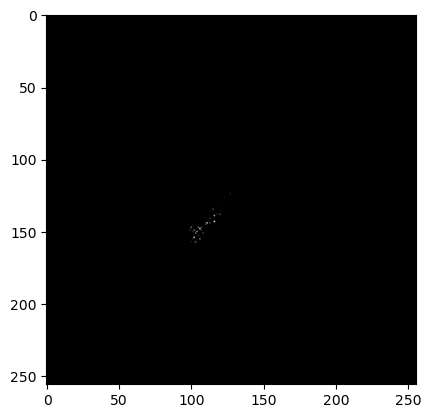

In [150]:
plt.imshow(images[2],cmap = 'Greys_r')
plt.show()

In [196]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

# --- Part 1: Core Function Definitions ---

def generate_bounded_random_paths(
    mu: NDArray[np.floating], cov: NDArray[np.floating], poisson_mean: float,
    num_paths: int, xlim: Tuple[float, float], ylim: Tuple[float, float], zlim: Tuple[float, float]
) -> List[NDArray[np.floating]]:
    """Generates multiple 3D random walk paths with boundary clipping."""
    init_pos = np.zeros((num_paths, 3), dtype=np.float32)
    init_pos[:, 0] = np.random.uniform(*xlim, size=num_paths)
    init_pos[:, 1] = np.random.uniform(*ylim, size=num_paths)
    steps_per_path = np.random.poisson(poisson_mean, size=num_paths)
    walk_steps = [np.random.multivariate_normal(mu, cov, size=s) for s in steps_per_path]
    final_paths: List[NDArray[np.floating]] = []
    for i, steps_array in enumerate(walk_steps):
        path = np.zeros((len(steps_array) + 1, 3), dtype=np.float32)
        path[1:] = np.cumsum(steps_array, axis=0)
        path += init_pos[i]
        np.clip(path[:, 0], *xlim, out=path[:, 0])
        np.clip(path[:, 1], *ylim, out=path[:, 1])
        np.clip(path[:, 2], *zlim, out=path[:, 2])
        final_paths.append(path)
    return final_paths

def generate_intensities_for_paths(
    paths: List[NDArray[np.floating]], intensity_decay_rate: float, intensity_noise_std: float
) -> List[NDArray[np.floating]]:
    """Generates intensity values for a list of 3D paths based on depth."""
    all_intensities: List[NDArray[np.floating]] = []
    for path in paths:
        if path.shape[0] == 0:
            all_intensities.append(np.array([], dtype=np.float32))
            continue
        z_coords = path[:, 2]
        base_intensities = np.exp(-intensity_decay_rate * z_coords)
        noise = np.random.normal(0.0, intensity_noise_std, size=path.shape[0])
        stochastic_intensities = np.maximum(0.0, base_intensities + noise)
        all_intensities.append(stochastic_intensities.astype(np.float32))
    return all_intensities

def project_path_to_image(
    path: NDArray[np.floating], intensities: NDArray[np.floating], image_dims: Tuple[int, int]
) -> NDArray[np.floating]:
    """Projects a single 3D path and its intensities onto a 2D image."""
    height, width = image_dims
    image = np.zeros(image_dims, dtype=np.float32)
    if path.shape[0] == 0:
        return image
    x_coords = path[:, 0].astype(int)
    y_coords = path[:, 1].astype(int)
    valid_indices = (x_coords >= 0) & (x_coords < width) & (y_coords >= 0) & (y_coords < height)
    np.maximum.at(image, (y_coords[valid_indices], x_coords[valid_indices]), intensities[valid_indices])
    return image

class ContactPointPredictor(nn.Module):
    """A CNN to predict contact point coordinates (y, x) from an image."""
    def __init__(self, height: int, width: int):
        super().__init__()
        # Simple architecture for demonstration
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * (height // 4) * (width // 4), 64), nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

# --- Part 2: Model Training Function ---
def train_contact_predictor(
    model: ContactPointPredictor, training_data: List[Tuple[NDArray, Tuple]],
    epochs: int, learning_rate: float
) -> ContactPointPredictor:
    """Trains the CNN model on the generated dataset."""
    print(f"--- Starting Training for {epochs} epochs ---")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for image, coords in training_data:
            optimizer.zero_grad()
            image_tensor = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
            coords_tensor = torch.tensor([coords], dtype=torch.float32)
            prediction = model(image_tensor)
            loss = loss_fn(prediction, coords_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(training_data)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
    print("--- Training Complete ---")
    return model

# --- Part 3: Prediction and Visualization ---
def predict_initial_contact(
    model: ContactPointPredictor, image: NDArray[np.floating]
) -> Tuple[float, float]:
    """Uses a trained model to predict the initial contact point on an image."""
    model.eval()
    with torch.no_grad():
        image_tensor = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
        predicted_coords = model(image_tensor).squeeze().cpu().numpy()
        return (predicted_coords[0], predicted_coords[1])

def visualize_prediction(
    image: NDArray[np.floating], true_coords: Tuple[int, int], pred_coords: Tuple[float, float]
):
    """Visualizes the image with true and predicted contact points."""
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='Grays_r', origin='lower')
    plt.scatter(true_coords[1], true_coords[0],
                edgecolor='white', facecolor='none', s=150, linewidth=2, label='True Contact')
    plt.scatter(pred_coords[1], pred_coords[0],
                marker='x', color='red', s=150, linewidth=2, label='Predicted Contact')
    plt.title("Prediction vs. Ground Truth")
    plt.legend()
    plt.show()

# --- Part 4: Main Execution Block ---
if __name__ == "__main__":
    # --- Hyperparameters ---
    IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH = 64, 64, 64
    NUM_TRAIN_SAMPLES = 8000
    NUM_TEST_SAMPLES = 2000
    POISSON_MEAN_STEPS = 100
    DRIFT = np.array([0.0, 0.0, 0.5])  # slight drift in z
    COV = np.diag([2.0, 2.0, 1.0]) # Diffusion
    DECAY_RATE = 0.05
    NOISE_STD = 0.1
    EPOCHS = 30
    LEARNING_RATE = 0.001

    # --- Data Generation ---
    print("Generating training data...")
    paths = generate_bounded_random_paths(
        mu=DRIFT, cov=COV, poisson_mean=POISSON_MEAN_STEPS, num_paths=NUM_TRAIN_SAMPLES + NUM_TEST_SAMPLES,
        xlim=(0, IMAGE_WIDTH), ylim=(0, IMAGE_HEIGHT), zlim=(0, IMAGE_DEPTH)
    )
    intensities = generate_intensities_for_paths(paths, DECAY_RATE, NOISE_STD)

    training_data = []
    for i in range(NUM_TRAIN_SAMPLES):
        img = project_path_to_image(paths[i], intensities[i], (IMAGE_HEIGHT, IMAGE_WIDTH))
        true_y, true_x = paths[i][0, 1], paths[i][0, 0]
        training_data.append((img, (true_y, true_x)))
    
    # --- Model Training ---
    model = ContactPointPredictor(height=IMAGE_HEIGHT, width=IMAGE_WIDTH)
    trained_model = train_contact_predictor(model, training_data, EPOCHS, LEARNING_RATE)


Generating training data...
--- Starting Training for 30 epochs ---
Epoch 1/30, Average Loss: 66.5320
Epoch 2/30, Average Loss: 23.7419
Epoch 3/30, Average Loss: 15.5637
Epoch 4/30, Average Loss: 11.9257
Epoch 5/30, Average Loss: 9.8796
Epoch 6/30, Average Loss: 8.5166
Epoch 7/30, Average Loss: 7.4648
Epoch 8/30, Average Loss: 6.5867
Epoch 9/30, Average Loss: 5.9062
Epoch 10/30, Average Loss: 5.3517
Epoch 11/30, Average Loss: 4.9089
Epoch 12/30, Average Loss: 4.5592
Epoch 13/30, Average Loss: 4.2379
Epoch 14/30, Average Loss: 3.9886
Epoch 15/30, Average Loss: 3.7625
Epoch 16/30, Average Loss: 3.5456
Epoch 17/30, Average Loss: 3.3911
Epoch 18/30, Average Loss: 3.2195
Epoch 19/30, Average Loss: 3.0942
Epoch 20/30, Average Loss: 2.9781
Epoch 21/30, Average Loss: 2.8558
Epoch 22/30, Average Loss: 2.7761
Epoch 23/30, Average Loss: 2.6884
Epoch 24/30, Average Loss: 2.6126
Epoch 25/30, Average Loss: 2.5682
Epoch 26/30, Average Loss: 2.4829
Epoch 27/30, Average Loss: 2.4226
Epoch 28/30, Averag


Performing inference on a test sample...
True Contact (y, x):      (31.21, 23.07)
Predicted Contact (y, x): (29.62, 20.43)


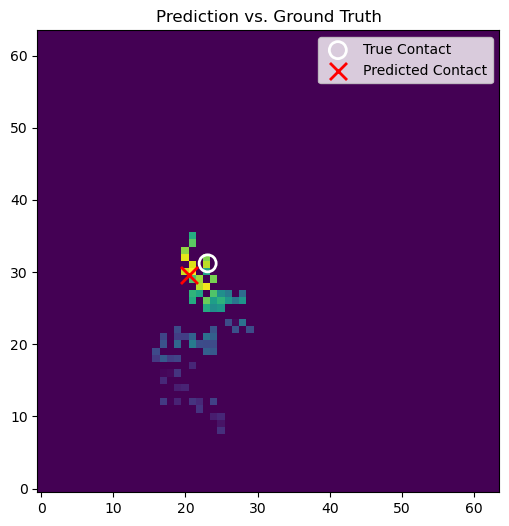

In [195]:

# --- Inference and Visualization ---
print("\nPerforming inference on a test sample...")
k = 73
test_idx = NUM_TRAIN_SAMPLES + k # Use the first sample after the training set
test_image = project_path_to_image(paths[test_idx], intensities[test_idx], (IMAGE_HEIGHT, IMAGE_WIDTH))
true_contact = (paths[test_idx][0, 1], paths[test_idx][0, 0])

predicted_contact = predict_initial_contact(trained_model, test_image)

print(f"True Contact (y, x):      ({true_contact[0]:.2f}, {true_contact[1]:.2f})")
print(f"Predicted Contact (y, x): ({predicted_contact[0]:.2f}, {predicted_contact[1]:.2f})")

visualize_prediction(test_image, true_contact, predicted_contact)

In [169]:
intensities

[array([0.88768524, 0.94262856, 0.840499  , 0.9140037 , 0.6925361 ,
        0.89373845, 0.80418044, 0.7507362 , 0.7037467 , 0.83623   ,
        0.6644492 , 0.70596904, 0.657479  , 0.7639409 , 0.7557882 ,
        0.60709196, 0.89211535, 0.6565733 , 0.662042  , 0.59655625,
        0.5139271 , 0.46723485, 0.45313007, 0.4852517 , 0.1869682 ,
        0.3966184 , 0.35938442, 0.35386315, 0.3578679 , 0.32385156,
        0.2207754 , 0.37805977, 0.5208729 , 0.44763026, 0.52481735,
        0.44124806, 0.3150081 , 0.45079914, 0.30829298, 0.41537783,
        0.34806594, 0.25713655, 0.14199099, 0.12065714, 0.20848873,
        0.12985237, 0.20433678, 0.32732695, 0.11393771, 0.33923763,
        0.36098263, 0.31349924, 0.20286004, 0.22578588, 0.11731748,
        0.03088997, 0.24640496, 0.22963785, 0.0038061 , 0.47840956,
        0.20662065, 0.        , 0.20888704, 0.04680351, 0.15253459,
        0.        , 0.12133537, 0.05736313, 0.        , 0.        ,
        0.04325459, 0.14625737, 0.1019972 , 0.04

Generating training data...
--- Starting Training for 50 epochs ---
Epoch 1/50, Average Loss: 163.4271
Epoch 2/50, Average Loss: 119.7831
Epoch 3/50, Average Loss: 107.4336
Epoch 4/50, Average Loss: 101.0571
Epoch 5/50, Average Loss: 90.7603
Epoch 6/50, Average Loss: 85.4518
Epoch 7/50, Average Loss: 83.2611
Epoch 8/50, Average Loss: 76.4647
Epoch 9/50, Average Loss: 74.4963
Epoch 10/50, Average Loss: 72.2346
Epoch 11/50, Average Loss: 66.9471
Epoch 12/50, Average Loss: 65.1909
Epoch 13/50, Average Loss: 63.5620
Epoch 14/50, Average Loss: 62.5867
Epoch 15/50, Average Loss: 61.1062
Epoch 16/50, Average Loss: 60.1931
Epoch 17/50, Average Loss: 58.5251
Epoch 18/50, Average Loss: 56.8097
Epoch 19/50, Average Loss: 56.9786
Epoch 20/50, Average Loss: 55.9021
Epoch 21/50, Average Loss: 54.5559
Epoch 22/50, Average Loss: 55.5314
Epoch 23/50, Average Loss: 54.5054
Epoch 24/50, Average Loss: 54.0978
Epoch 25/50, Average Loss: 53.9938
Epoch 26/50, Average Loss: 52.3250
Epoch 27/50, Average Loss: 

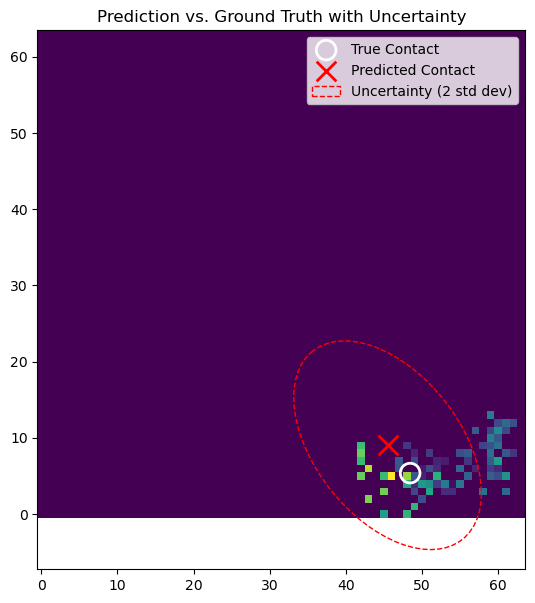

In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# --- Part 1: Core Data Generation Functions ---

def generate_bounded_random_paths(
    mu: NDArray[np.floating], cov: NDArray[np.floating], poisson_mean: float,
    num_paths: int, xlim: Tuple[float, float], ylim: Tuple[float, float], zlim: Tuple[float, float]
) -> List[NDArray[np.floating]]:
    """Generates multiple 3D random walk paths with boundary clipping."""
    init_pos = np.zeros((num_paths, 3), dtype=np.float32)
    init_pos[:, 0] = np.random.uniform(*xlim, size=num_paths)
    init_pos[:, 1] = np.random.uniform(*ylim, size=num_paths)
    steps_per_path = np.random.poisson(poisson_mean, size=num_paths)
    walk_steps = [np.random.multivariate_normal(mu, cov, size=s) for s in steps_per_path]
    final_paths: List[NDArray[np.floating]] = []
    for i, steps_array in enumerate(walk_steps):
        path = np.zeros((len(steps_array) + 1, 3), dtype=np.float32)
        path[1:] = np.cumsum(steps_array, axis=0)
        path += init_pos[i]
        np.clip(path[:, 0], *xlim, out=path[:, 0])
        np.clip(path[:, 1], *ylim, out=path[:, 1])
        np.clip(path[:, 2], *zlim, out=path[:, 2])
        final_paths.append(path)
    return final_paths

def generate_intensities_for_paths(
    paths: List[NDArray[np.floating]], intensity_decay_rate: float, intensity_noise_std: float
) -> List[NDArray[np.floating]]:
    """Generates intensity values for a list of 3D paths based on depth."""
    all_intensities: List[NDArray[np.floating]] = []
    for path in paths:
        if path.shape[0] == 0:
            all_intensities.append(np.array([], dtype=np.float32))
            continue
        z_coords = path[:, 2]
        base_intensities = np.exp(-intensity_decay_rate * z_coords)
        noise = np.random.normal(0.0, intensity_noise_std, size=path.shape[0])
        stochastic_intensities = np.maximum(0.0, base_intensities + noise)
        all_intensities.append(stochastic_intensities.astype(np.float32))
    return all_intensities

def project_path_to_image(
    path: NDArray[np.floating], intensities: NDArray[np.floating], image_dims: Tuple[int, int]
) -> NDArray[np.floating]:
    """Projects a single 3D path and its intensities onto a 2D image."""
    height, width = image_dims
    image = np.zeros(image_dims, dtype=np.float32)
    if path.shape[0] == 0:
        return image
    x_coords = path[:, 0].astype(int)
    y_coords = path[:, 1].astype(int)
    valid_indices = (x_coords >= 0) & (x_coords < width) & (y_coords >= 0) & (y_coords < height)
    np.maximum.at(image, (y_coords[valid_indices], x_coords[valid_indices]), intensities[valid_indices])
    return image

# --- Part 2: Model Definition with Dropout ---
class ContactPointPredictorWithDropout(nn.Module):
    """A CNN with Dropout layers to enable uncertainty estimation."""
    def __init__(self, height: int, width: int, dropout_rate: float = 0.5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * (height // 4) * (width // 4), 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, 2)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

# --- Part 3: Model Training Function ---
def train_contact_predictor(
    model: ContactPointPredictorWithDropout, training_data: List[Tuple[NDArray, Tuple]],
    epochs: int, learning_rate: float
) -> ContactPointPredictorWithDropout:
    """Trains the CNN model on the generated dataset."""
    print(f"--- Starting Training for {epochs} epochs ---")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    model.train() # This correctly enables Dropout for regularization during training
    for epoch in range(epochs):
        total_loss = 0
        for image, coords in training_data:
            optimizer.zero_grad()
            image_tensor = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
            coords_tensor = torch.tensor([coords], dtype=torch.float32)
            prediction = model(image_tensor)
            loss = loss_fn(prediction, coords_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(training_data)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
    print("--- Training Complete ---")
    return model

# --- Part 4: Prediction and Visualization with Uncertainty ---
def predict_with_uncertainty(
    model: ContactPointPredictorWithDropout, image: NDArray[np.floating], num_passes: int = 50
) -> Tuple[NDArray[np.floating], NDArray[np.floating]]:
    """Performs prediction with MC Dropout to estimate uncertainty."""
    model.train() # Keep dropout active for uncertainty estimation
    predictions = []
    with torch.no_grad():
        for _ in range(num_passes):
            image_tensor = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
            pred = model(image_tensor).squeeze().cpu().numpy()
            predictions.append(pred)
    predictions = np.array(predictions)
    mean_prediction = np.mean(predictions, axis=0)
    covariance_matrix = np.cov(predictions, rowvar=False)
    return mean_prediction, covariance_matrix

def visualize_with_uncertainty(
    image: NDArray[np.floating], true_coords: Tuple[int, int],
    mean_pred: NDArray[np.floating], covariance: NDArray[np.floating]
):
    """Visualizes the image, true/predicted points, and an uncertainty ellipse."""
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image, cmap='viridis', origin='lower')
    ax.scatter(true_coords[1], true_coords[0],
               edgecolor='white', facecolor='none', s=200, linewidth=2, label='True Contact')
    ax.scatter(mean_pred[1], mean_pred[0],
               marker='x', color='red', s=200, linewidth=2, label='Predicted Contact')
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
    width, height = 2 * 2 * np.sqrt(eigenvals) # 2 standard deviations
    ellipse = Ellipse(xy=(mean_pred[1], mean_pred[0]), width=width, height=height,
                      angle=angle, edgecolor='red', facecolor='none',
                      linestyle='--', label='Uncertainty (2 std dev)')
    ax.add_patch(ellipse)
    ax.set_title("Prediction vs. Ground Truth with Uncertainty")
    ax.legend()
    plt.show()

# --- Part 5: Main Execution Block ---
if __name__ == "__main__":
    # --- Hyperparameters ---
    IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH = 64, 64, 64
    NUM_TRAIN_SAMPLES = 10000
    NUM_TEST_SAMPLES = 1
    POISSON_MEAN_STEPS = 100
    DRIFT = np.array([0.0, 0.0, 0.5])
    COV = np.diag([2.0, 2.0, 1.0])
    DECAY_RATE = 0.05
    NOISE_STD = 0.1
    DROPOUT_RATE = 0.5
    EPOCHS = 50
    LEARNING_RATE = 0.001
    MC_PASSES = 100 # Number of forward passes for uncertainty estimation

    # --- Data Generation ---
    print("Generating training data...")
    paths = generate_bounded_random_paths(
        mu=DRIFT, cov=COV, poisson_mean=POISSON_MEAN_STEPS, num_paths=NUM_TRAIN_SAMPLES + NUM_TEST_SAMPLES,
        xlim=(0, IMAGE_WIDTH), ylim=(0, IMAGE_HEIGHT), zlim=(0, IMAGE_DEPTH)
    )
    intensities = generate_intensities_for_paths(paths, DECAY_RATE, NOISE_STD)

    training_data = []
    for i in range(NUM_TRAIN_SAMPLES):
        img = project_path_to_image(paths[i], intensities[i], (IMAGE_HEIGHT, IMAGE_WIDTH))
        true_y, true_x = paths[i][0, 1], paths[i][0, 0]
        training_data.append((img, (true_y, true_x)))
    
    # --- Model Training ---
    model = ContactPointPredictorWithDropout(
        height=IMAGE_HEIGHT, width=IMAGE_WIDTH, dropout_rate=DROPOUT_RATE
    )
    trained_model = train_contact_predictor(model, training_data, EPOCHS, LEARNING_RATE)

    # --- Inference and Visualization ---
    print("\nPerforming inference with uncertainty estimation on a test sample...")
    test_idx = NUM_TRAIN_SAMPLES
    test_image = project_path_to_image(paths[test_idx], intensities[test_idx], (IMAGE_HEIGHT, IMAGE_WIDTH))
    true_contact = (paths[test_idx][0, 1], paths[test_idx][0, 0])
    
    mean_prediction, covariance = predict_with_uncertainty(
        trained_model, test_image, num_passes=MC_PASSES
    )
    
    print(f"True Contact (y, x):          ({true_contact[0]:.2f}, {true_contact[1]:.2f})")
    print(f"Mean Prediction (y, x):       ({mean_prediction[0]:.2f}, {mean_prediction[1]:.2f})")
    print(f"Uncertainty (Covariance Matrix):\n{covariance}")

    visualize_with_uncertainty(test_image, true_contact, mean_prediction, covariance)